In [2]:
# =============================================================================
#  AUTOMATED DERMOSCOPY CLASSIFIER (GPU-ACCELERATED)
#  Method: ABCD Rule + Texture Analysis with Data-Driven Optimization
#  Platform: Kaggle GPU (CuPy)
# =============================================================================

import os
import cv2
import numpy as np
import pandas as pd
import cupy as cp
from math import pi
import time

# -----------------------------------------------------------------------------
# 1. CONFIGURATION & PATHS
# -----------------------------------------------------------------------------
METADATA_PATH = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
IMG_DIRS = [
    "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1",
    "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"
]
TARGET_SIZE = (224, 224)

# -----------------------------------------------------------------------------
# 2. GPU HELPER FUNCTIONS (CUPY KERNELS)
# -----------------------------------------------------------------------------
def gpu_gray_world(img_gpu):
    """
    Performs Gray World Color Constancy on GPU to remove lighting bias.
    """
    b, g, r = img_gpu[:,:,0], img_gpu[:,:,1], img_gpu[:,:,2]
    b_mean, g_mean, r_mean = float(b.mean()), float(g.mean()), float(r.mean())
    k = (b_mean + g_mean + r_mean) / 3.0
    
    # Vectorized scaling
    if b_mean > 0: b = cp.clip(b * (k / b_mean), 0, 255)
    if g_mean > 0: g = cp.clip(g * (k / g_mean), 0, 255)
    if r_mean > 0: r = cp.clip(r * (k / r_mean), 0, 255)
    
    return cp.dstack((b, g, r)).astype(cp.uint8)

def gpu_texture_features(gray_gpu, mask_gpu):
    """
    Calculates Texture roughness (Laplacian) and Contrast on GPU.
    Replaces slow GLCM with vectorized gradient analysis.
    """
    roi = gray_gpu * (mask_gpu > 0)
    
    # Gradient Calculation (Edges)
    # Fix shape mismatch by slicing
    dy = cp.abs(cp.diff(roi, axis=0))[:, :-1]
    dx = cp.abs(cp.diff(roi, axis=1))[:-1, :]
    edges = dy + dx
    
    valid_pixels = edges[edges > 0]
    if valid_pixels.size == 0:
        return 0.0, 0.0
    
    # Roughness (Standard Deviation of edges)
    roughness = float(valid_pixels.std())
    # Contrast (Mean intensity of edges)
    contrast = float(valid_pixels.mean())
    
    return roughness, contrast

def gpu_color_features(img_gpu, mask_gpu):
    """
    Extracts color statistics and Blue-White veil ratio on GPU.
    """
    # Filter by mask
    mask_flat = mask_gpu.flatten() > 0
    if not cp.any(mask_flat):
        return 0.0, 0.0, 0.0
    
    # Extract ROI pixels
    pixels = img_gpu.reshape(-1, 3)[mask_flat] # BGR
    
    # 1. Color Standard Deviation (Chaos)
    col_std = float(pixels.std())
    
    # 2. Blue Ratio (Blue / Red channel intensity)
    b = pixels[:, 0].astype(cp.float32) # BGR: 0 is Blue
    r = pixels[:, 2].astype(cp.float32) # BGR: 2 is Red
    blue_ratio = float(cp.mean(b / (r + 1e-6)))
    
    # 3. Color Range (Max - Min)
    col_range = float(cp.mean(pixels.max(axis=1) - pixels.min(axis=1)))
    
    return col_std, blue_ratio, col_range

# -----------------------------------------------------------------------------
# 3. CPU SEGMENTATION & SHAPE ANALYSIS
# -----------------------------------------------------------------------------
def process_image_pipeline(path):
    # Load (CPU)
    bgr = cv2.imread(path)
    if bgr is None: return None
    
    # --- GPU STEP 1: PREPROCESSING ---
    bgr_gpu = cp.asarray(bgr)
    bgr_norm_gpu = gpu_gray_world(bgr_gpu)
    
    # --- HYBRID STEP: SEGMENTATION (CPU) ---
    img_cpu = cp.asnumpy(bgr_norm_gpu)
    gray = cv2.cvtColor(img_cpu, cv2.COLOR_BGR2GRAY)
    
    # Pre-processing for Otsu
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Morphological Cleanup
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    # Keep largest blob
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    compactness = 1.0
    asymmetry = 0.0
    border_irr = 0.0
    
    if cnts:
        c = max(cnts, key=cv2.contourArea)
        area = cv2.contourArea(c)
        perim = cv2.arcLength(c, True)
        
        if perim > 0:
            # Shape Features
            compactness = (4 * pi * area) / (perim**2)
            border_irr = (perim**2) / (4 * pi * area)
            
            # Refine mask
            mask = np.zeros_like(mask)
            cv2.drawContours(mask, [c], -1, 255, -1)
            
            # Simple Asymmetry (Bounding Box ROI Flip)
            x,y,w,h = cv2.boundingRect(c)
            roi = mask[y:y+h, x:x+w]
            asymmetry = np.abs(roi - np.flip(roi, axis=1)).mean() / 255.0

    # --- GPU STEP 2: FEATURE EXTRACTION ---
    mask_gpu = cp.asarray(mask)
    gray_gpu = cp.asarray(gray)
    
    roughness, txt_contrast = gpu_texture_features(gray_gpu, mask_gpu)
    col_std, blue_ratio, col_range = gpu_color_features(bgr_norm_gpu, mask_gpu)
    
    return {
        "asymmetry": asymmetry,
        "compactness": compactness,
        "border_irr": border_irr,
        "col_std": col_std,
        "col_range": col_range,
        "blue_ratio": blue_ratio,
        "txt_roughness": roughness,
        "txt_contrast": txt_contrast
    }

# -----------------------------------------------------------------------------
# 4. MAIN EXECUTION LOOP
# -----------------------------------------------------------------------------
def run_analysis():
    print("="*60)
    print("STARTING AUTOMATED DERMOSCOPY ANALYSIS")
    print(f"Platform: {cp.cuda.runtime.getDeviceCount()} GPU(s) detected")
    print("="*60)
    
    # Load Metadata
    df_meta = pd.read_csv(METADATA_PATH)
    malignant_types = ['mel', 'bcc', 'akiec']
    df_meta['dx_binary'] = df_meta['dx'].apply(lambda x: "Malignant" if x in malignant_types else "Benign")
    
    # Map Images
    img_paths = {}
    for d in IMG_DIRS:
        if os.path.exists(d):
            for f in os.listdir(d):
                img_paths[f.split('.')[0]] = os.path.join(d, f)
    
    print(f"Total Images in Metadata: {len(df_meta)}")
    print("Beginning Feature Extraction...\n")
    
    results = []
    start_time = time.time()
    
    # Processing Loop
    processed_count = 0
    for idx, row in df_meta.iterrows():
        pid = row['image_id']
        if pid in img_paths:
            try:
                feats = process_image_pipeline(img_paths[pid])
                if feats:
                    feats['true_label'] = row['dx_binary']
                    results.append(feats)
                    processed_count += 1
            except Exception:
                continue
                
        if processed_count % 1000 == 0 and processed_count > 0:
            elapsed = time.time() - start_time
            print(f"  > Processed {processed_count} images ({processed_count/elapsed:.1f} img/sec)")

    df = pd.DataFrame(results)
    print(f"\nExtraction Complete. Total Valid Samples: {len(df)}")
    
    return df

# -----------------------------------------------------------------------------
# 5. DATA-DRIVEN CALIBRATION & OPTIMIZATION
# -----------------------------------------------------------------------------
def calibrate_and_classify(df):
    print("\n" + "="*60)
    print("CALIBRATING DIAGNOSTIC THRESHOLDS")
    print("="*60)
    
    mal = df[df['true_label'] == 'Malignant']
    ben = df[df['true_label'] == 'Benign']
    
    features = [c for c in df.columns if c != 'true_label']
    rules = []
    
    print(f"{'Feature':<20} | {'Effect Size':<12} | {'Direction'}")
    print("-" * 50)
    
    # 1. Feature Weighting (Cohen's d)
    for f in features:
        mu_m, std_m = mal[f].mean(), mal[f].std()
        mu_b, std_b = ben[f].mean(), ben[f].std()
        
        pooled_std = np.sqrt((std_m**2 + std_b**2) / 2) + 1e-9
        effect_size = abs(mu_m - mu_b) / pooled_std
        
        # Determine if Malignant is higher or lower
        direction = 1 if mu_m > mu_b else -1
        dir_str = "High Risk" if direction == 1 else "Low Risk"
        
        # Calculate optimal separation threshold (Midpoint)
        threshold = (mu_m + mu_b) / 2.0
        
        if effect_size > 0.05:
            rules.append({
                'feature': f,
                'weight': effect_size,
                'threshold': threshold,
                'direction': direction
            })
            print(f"{f:<20} | {effect_size:.4f}       | Malignant is {dir_str}")

    # 2. Score Calculation
    def get_score(row):
        score = 0
        total_weight = sum(r['weight'] for r in rules) + 1e-9
        for r in rules:
            val = row[r['feature']]
            # Normalize risk contribution
            if r['direction'] == 1:
                if val >= r['threshold']: score += r['weight']
            else:
                if val < r['threshold']: score += r['weight']
        return score / total_weight

    df['risk_score'] = df.apply(get_score, axis=1)
    
    # 3. Optimize Cutoff (Youden's Index)
    print("\nOptimizing Sensitivity/Specificity Balance...")
    best_metrics = {'Acc': 0, 'Sens': 0, 'Spec': 0, 'F1': 0, 'Cutoff': 0}
    
    for cutoff in np.linspace(df['risk_score'].min(), df['risk_score'].max(), 100):
        pred_mal = df['risk_score'] >= cutoff
        true_mal = df['true_label'] == 'Malignant'
        
        TP = (pred_mal & true_mal).sum()
        TN = (~pred_mal & ~true_mal).sum()
        FP = (pred_mal & ~true_mal).sum()
        FN = (~pred_mal & true_mal).sum()
        
        if (TP+FN) == 0 or (TN+FP) == 0: continue
            
        sens = TP / (TP+FN)
        spec = TN / (TN+FP)
        acc = (TP+TN) / len(df)
        
        # Maximize Youden's J (Sens + Spec - 1)
        if (sens + spec) > (best_metrics['Sens'] + best_metrics['Spec']):
            f1 = 2*TP / (2*TP + FP + FN) if (2*TP+FP+FN) > 0 else 0
            best_metrics = {'Acc': acc, 'Sens': sens, 'Spec': spec, 'F1': f1, 'Cutoff': cutoff}

    # 4. Final Output
    print("\n" + "="*60)
    print("FINAL CLASSIFICATION RESULTS")
    print("="*60)
    print(f"Optimal Risk Threshold: {best_metrics['Cutoff']:.4f}")
    print("-" * 30)
    print(f"Accuracy:    {best_metrics['Acc']*100:.2f}%")
    print(f"Sensitivity: {best_metrics['Sens']*100:.2f}%  (Malignant Detection Rate)")
    print(f"Specificity: {best_metrics['Spec']*100:.2f}%  (Benign Exclusion Rate)")
    print(f"F1-Score:    {best_metrics['F1']*100:.2f}%")
    print("="*60)
    
    # Save Results
    df['prediction'] = df['risk_score'].apply(lambda x: "Malignant" if x >= best_metrics['Cutoff'] else "Benign")
    df.to_csv("final_project_results.csv", index=False)
    print("Detailed results saved to 'final_project_results.csv'")

# -----------------------------------------------------------------------------
# RUN
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    df_results = run_analysis()
    if not df_results.empty:
        calibrate_and_classify(df_results)
    else:
        print("Error: No data processed.")

STARTING AUTOMATED DERMOSCOPY ANALYSIS
Platform: 2 GPU(s) detected
Total Images in Metadata: 10015
Beginning Feature Extraction...

  > Processed 1000 images (29.5 img/sec)
  > Processed 2000 images (33.7 img/sec)
  > Processed 3000 images (36.2 img/sec)
  > Processed 4000 images (36.9 img/sec)
  > Processed 5000 images (37.6 img/sec)
  > Processed 6000 images (37.9 img/sec)
  > Processed 7000 images (38.3 img/sec)
  > Processed 8000 images (38.7 img/sec)
  > Processed 9000 images (39.1 img/sec)
  > Processed 10000 images (39.3 img/sec)

Extraction Complete. Total Valid Samples: 10015

CALIBRATING DIAGNOSTIC THRESHOLDS
Feature              | Effect Size  | Direction
--------------------------------------------------
asymmetry            | 0.4784       | Malignant is High Risk
compactness          | 0.6818       | Malignant is Low Risk
border_irr           | 0.5192       | Malignant is High Risk
col_std              | 0.1347       | Malignant is Low Risk
col_range            | 0.4183   

Selected Sample Image: ISIC_0024615.jpg
Generating Pipeline Visualization...
 > Saved: 'pipeline_visualization.png'


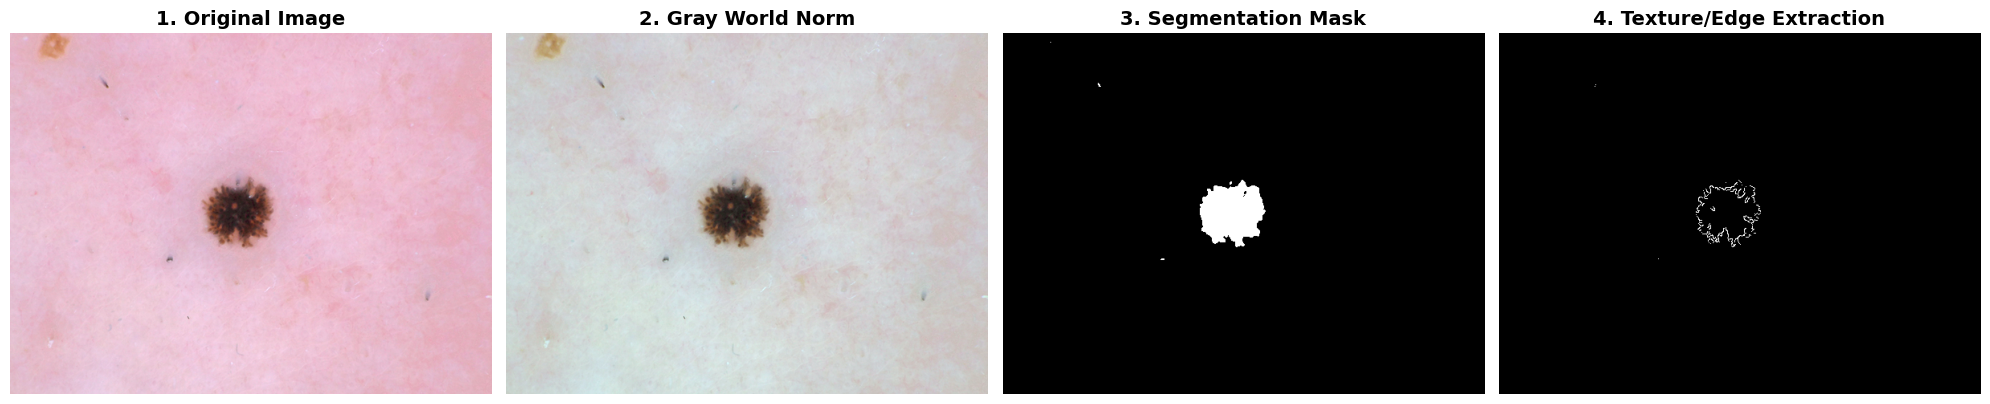

Generating Pipeline Visualization...
 > Saved: 'pipeline_visualization.png'


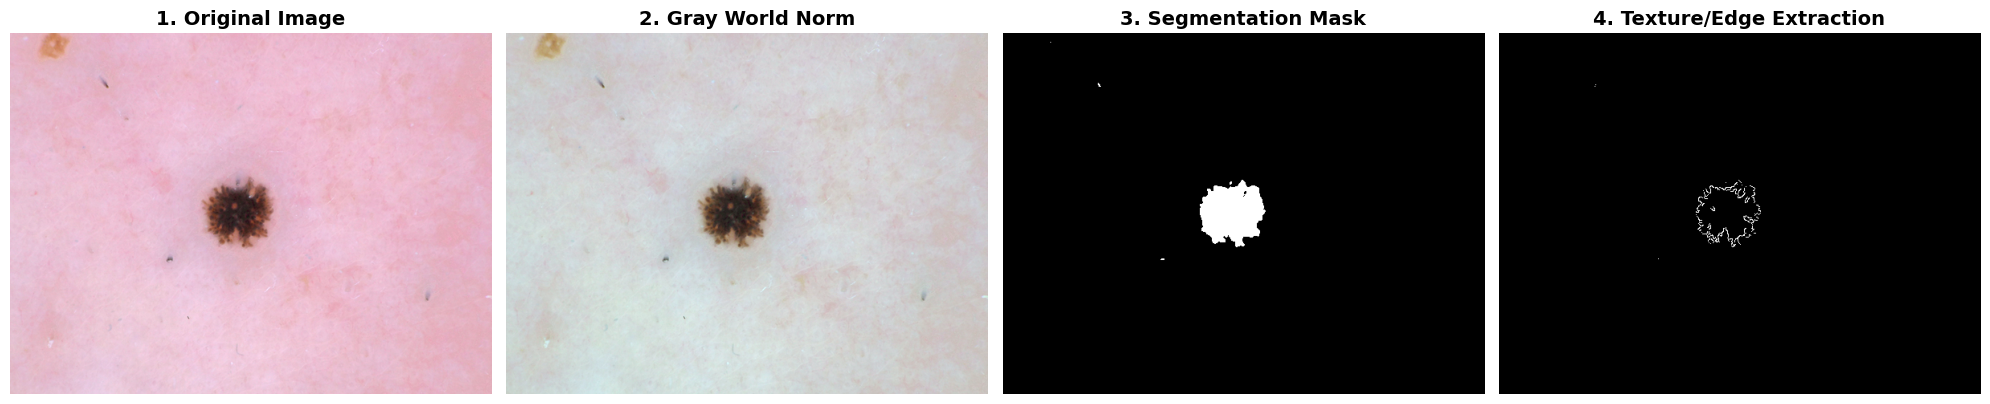

Generating Feature Distributions...
 > Saved: 'feature_distributions.png'


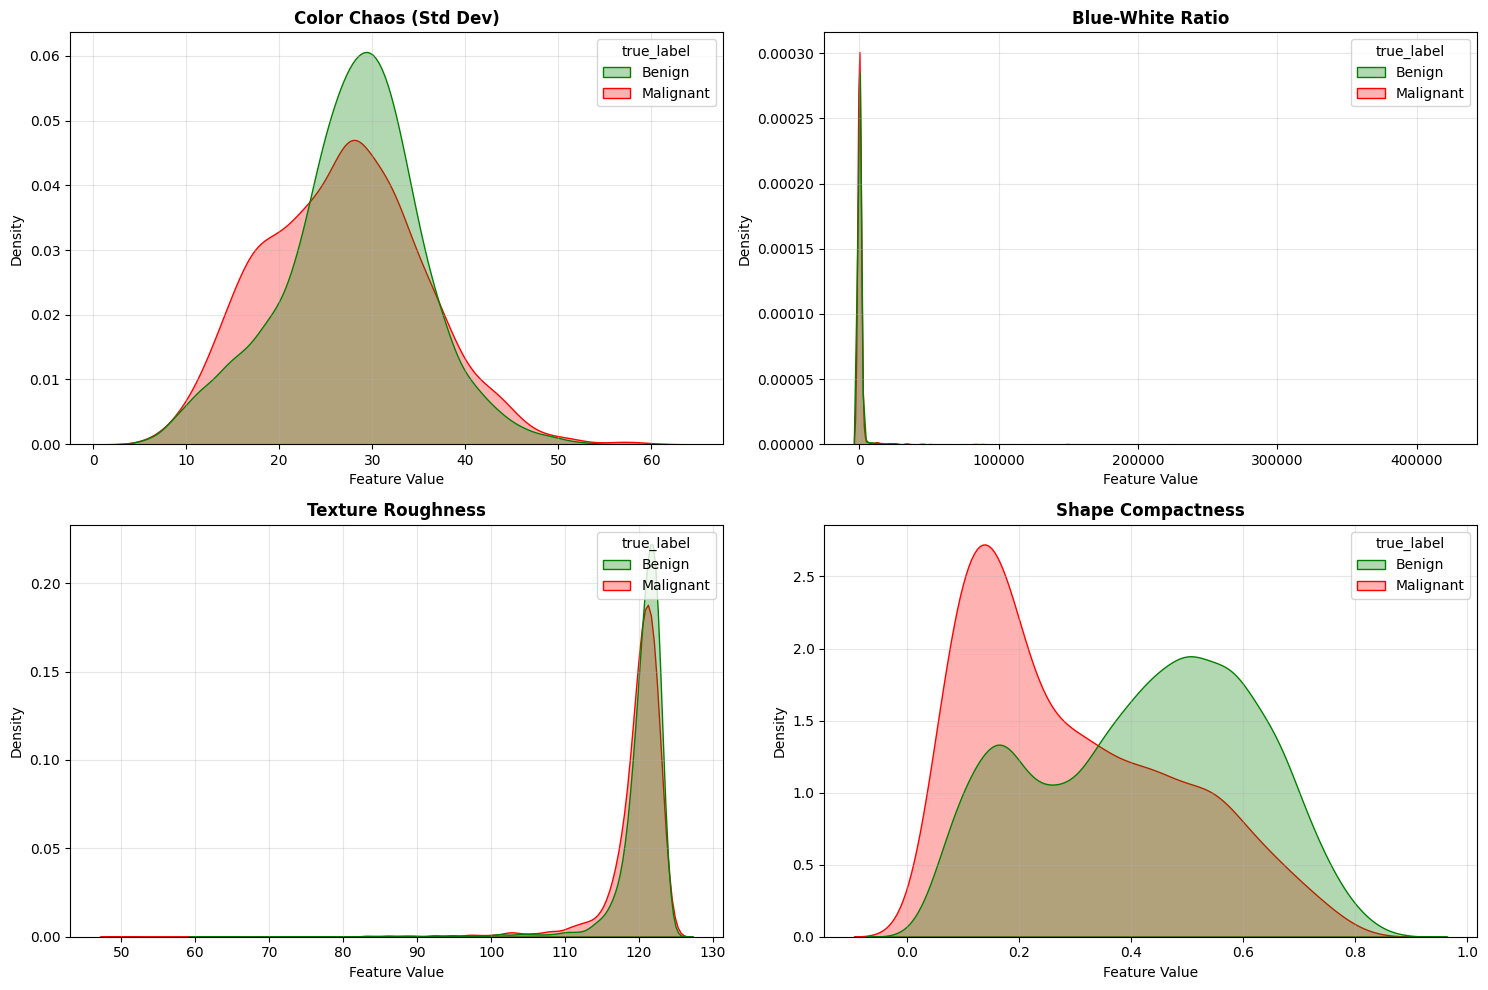

In [6]:
# =============================================================================
#  REPORT FIGURE GENERATOR (RANDOM SAMPLE VERSION)
#  Generates: pipeline_visualization.png using a RANDOM image each time.
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
import os
import random
import warnings

# Suppress warnings for cleaner output
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# --- CONFIGURATION ---
IMG_DIR = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1"

# Get a list of all images and pick a RANDOM one
if os.path.exists(IMG_DIR):
    all_files = [f for f in os.listdir(IMG_DIR) if f.endswith('.jpg')]
    if len(all_files) > 0:
        selected_filename = random.choice(all_files)
        IMG_PATH = os.path.join(IMG_DIR, selected_filename)
        print(f"Selected Sample Image: {selected_filename}")
    else:
        print("Error: No images found in directory.")
        IMG_PATH = None
else:
    print("Error: Directory not found.")
    IMG_PATH = None

def generate_pipeline_figure():
    if IMG_PATH is None: return

    print("Generating Pipeline Visualization...")
    
    # 1. Load Image
    bgr = cv2.imread(IMG_PATH)
    if bgr is None:
        print(f"Error: Could not load {IMG_PATH}")
        return
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    
    # 2. Gray World (Color Constancy)
    b, g, r = cv2.split(bgr)
    avg = (b.mean() + g.mean() + r.mean()) / 3
    # Use 1e-6 to avoid divide by zero
    b = np.clip(b * (avg / (b.mean() + 1e-6)), 0, 255).astype(np.uint8)
    g = np.clip(g * (avg / (g.mean() + 1e-6)), 0, 255).astype(np.uint8)
    r = np.clip(r * (avg / (r.mean() + 1e-6)), 0, 255).astype(np.uint8)
    gw = cv2.merge([r, g, b]) # Merge back (RGB for display)
    
    # 3. Segmentation (Otsu)
    gray = cv2.cvtColor(gw, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # 4. Texture/Edge Analysis
    edges = cv2.Canny(gray, 100, 200)
    edges_masked = cv2.bitwise_and(edges, edges, mask=mask)

    # --- PLOTTING ---
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    titles = ["1. Original Image", "2. Gray World Norm", "3. Segmentation Mask", "4. Texture/Edge Extraction"]
    images = [rgb, gw, mask, edges_masked]
    
    for i in range(4):
        ax[i].imshow(images[i], cmap='gray' if i > 1 else None)
        ax[i].set_title(titles[i], fontsize=14, fontweight='bold')
        ax[i].axis('off')
    
    plt.tight_layout()
    plt.savefig("pipeline_visualization.png", dpi=300, bbox_inches='tight')
    print(" > Saved: 'pipeline_visualization.png'")
    plt.show()

# Run the function
generate_pipeline_figure()

def generate_distribution_figure():
    print("Generating Feature Distributions...")
    
    # Load the results from the previous step
    csv_path = "final_project_results.csv"
    if not os.path.exists(csv_path):
        print("Error: 'final_project_results.csv' not found. Run the main classifier code first.")
        return

    df = pd.read_csv(csv_path)

    # Select key features to visualize separation
    features = ['col_std', 'blue_ratio', 'txt_roughness', 'compactness']
    titles = ['Color Chaos (Std Dev)', 'Blue-White Ratio', 'Texture Roughness', 'Shape Compactness']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        # Using KDE plot to show probability density
        sns.kdeplot(data=df, x=features[i], hue='true_label', fill=True, 
                    ax=ax, palette={'Malignant': 'red', 'Benign': 'green'}, 
                    common_norm=False, alpha=0.3)
        
        ax.set_title(titles[i], fontsize=12, fontweight='bold')
        ax.set_xlabel("Feature Value")
        ax.set_ylabel("Density")
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("feature_distributions.png", dpi=300, bbox_inches='tight')
    print(" > Saved: 'feature_distributions.png'")
    plt.show()

# --- RUN GENERATORS ---
generate_pipeline_figure()
generate_distribution_figure()

In [ ]:
# =============================================================================
#  ADVANCED PERFORMANCE VISUALIZATION (DISPLAY ENABLED)
#  Generates and Shows:
#  1. Confusion Matrix
#  2. ROC Curve
#  3. 2D Decision Boundary Scatter
# =============================================================================

from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

def generate_performance_plots():
    print("Generating Advanced Performance Plots...")
    
    # Load Data
    csv_path = "final_project_results.csv"
    if not os.path.exists(csv_path):
        print("Error: 'final_project_results.csv' not found. Please run the main classifier code first.")
        return
    df = pd.read_csv(csv_path)

    # Convert labels to binary for Math
    y_true = (df['true_label'] == 'Malignant').astype(int)
    y_pred = (df['prediction'] == 'Malignant').astype(int)
    y_score = df['risk_score']

    # --- PLOT 1: CONFUSION MATRIX ---
    # Logic: [True Negative, False Positive]
    #        [False Negative, True Positive]
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Benign', 'Predicted Malignant'],
                yticklabels=['Actual Benign', 'Actual Malignant'],
                annot_kws={"size": 16, "weight": "bold"})
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig("confusion_matrix.png", dpi=300)
    print(" > Saved: 'confusion_matrix.png'")
    plt.show()  # <--- DISPLAYS ON SCREEN

    # --- PLOT 2: ROC CURVE ---
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("roc_curve.png", dpi=300)
    print(" > Saved: 'roc_curve.png'")
    plt.show() # <--- DISPLAYS ON SCREEN

    # --- PLOT 3: 2D FEATURE SCATTER ---
    # We plot the two strongest features against each other to show separability
    plt.figure(figsize=(5, 5))
    
    # Randomly sample 2000 points to avoid overplotting if dataset is huge
    if len(df) > 2000:
        plot_df = df.sample(2000, random_state=42)
    else:
        plot_df = df

    sns.scatterplot(data=plot_df, x='col_std', y='txt_roughness', hue='true_label', 
                    palette={'Malignant': 'red', 'Benign': 'green'}, alpha=0.6, s=30)
    
    plt.title('Clinical Decision Space: Color vs. Texture', fontsize=16, fontweight='bold')
    plt.xlabel('Color Chaos (Standard Deviation)', fontsize=12)
    plt.ylabel('Texture Roughness (Laplacian)', fontsize=12)
    plt.legend(title='Diagnosis', loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("decision_scatter.png", dpi=300)
    print(" > Saved: 'decision_scatter.png'")
    plt.show() # <--- DISPLAYS ON SCREEN

# Run
generate_performance_plots()

In [7]:
# ===== SMART DATA-DRIVEN CLASSIFIER (Optimized Weights & Youden's Index) =====
# Paste and run as a single Kaggle cell.

import os, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from math import pi

# -------------------------
# Config / paths (Kaggle)
# -------------------------
METADATA = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
IMG_DIR1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1"
IMG_DIR2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"

# -------------------------
# 1) Load metadata & map dx to binary
# -------------------------
df_meta = pd.read_csv(METADATA)
def map_dx_to_binary(dx):
    malignant = ['mel', 'bcc', 'akiec']
    return "Malignant" if str(dx).strip().lower() in malignant else "Benign"
df_meta['dx_binary'] = df_meta['dx'].apply(map_dx_to_binary)

# -------------------------
# 2) Image I/O and preprocessing
# -------------------------
def load_image(path):
    bgr = cv2.imread(path)
    if bgr is None: return None
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    return rgb

def remove_hair(rgb):
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, thresh = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    return cv2.inpaint(rgb, thresh, 3, cv2.INPAINT_TELEA)

def preprocess_image(rgb, target_size=(224,224)):
    rgb_dehaired = remove_hair(rgb)
    rgb_resized = cv2.resize(rgb_dehaired, target_size, interpolation=cv2.INTER_AREA)
    rgb_denoised = cv2.medianBlur(rgb_resized, ksize=3)
    gray = cv2.cvtColor(rgb_denoised, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray_enhanced = clahe.apply(gray)
    return gray_enhanced, rgb_resized

# -------------------------
# 3) Improved segmentation
# -------------------------
def max_entropy_threshold(gray):
    hist, _ = np.histogram(gray.flatten(), bins=256, range=(0,256))
    hist = hist.astype(np.float64); p = hist / (hist.sum() + 1e-12)
    P1 = np.cumsum(p); P2 = 1.0 - P1; eps = 1e-12
    H1 = np.zeros(256); H2 = np.zeros(256)
    for t in range(256):
        if P1[t] > 0:
            p1_norm = p[:t+1] / (P1[t] + eps)
            H1[t] = -np.sum(p1_norm * np.log(p1_norm + eps))
        if P2[t] > 0:
            p2_norm = p[t+1:] / (P2[t] + eps)
            H2[t] = -np.sum(p2_norm * np.log(p2_norm + eps))
    return int(np.argmax(H1 + H2))

def segment_lesion(gray):
    t = max_entropy_threshold(gray)
    _, mask = cv2.threshold(gray, t, 255, cv2.THRESH_BINARY)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3,3),np.uint8), iterations=2)
    
    # Keep largest component
    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num > 1:
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        mask = np.zeros_like(mask)
        mask[labels == largest_label] = 255

    # Fallback if segmentation failed (too small/large)
    ratio = (mask>0).sum() / mask.size
    if ratio < 0.01 or ratio > 0.9:
        mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                     cv2.THRESH_BINARY_INV, 51, 5)
    return mask

# -------------------------
# 4, 5, 6) Feature Extraction (Condensed)
# -------------------------
def get_shape_features(mask):
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts: return {"asymmetry":0,"compactness":1,"eccentricity":0,"solidity":1,"border_irr":1}
    c = max(cnts, key=cv2.contourArea)
    area, perim = cv2.contourArea(c), cv2.arcLength(c, True)
    if perim == 0: perim = 1
    
    # Asymmetry
    M = cv2.moments(c)
    cx, cy = (int(M['m10']/M['m00']), int(M['m01']/M['m00'])) if M['m00'] else (0,0)
    x,y,w,h = cv2.boundingRect(c)
    roi = mask[y:y+h, x:x+w]
    # Simple asymmetry proxy: difference between flipped ROI
    asym = np.abs(roi - np.flip(roi, axis=1)).mean() / 255.0
    
    hull = cv2.convexHull(c)
    solidity = area / cv2.contourArea(hull) if cv2.contourArea(hull)>0 else 1
    compactness = (4*pi*area)/(perim**2)
    if len(c) >= 5:
        try:
            (MA, ma), _ = cv2.fitEllipse(c)[1]
            eccentricity = np.sqrt(1-(MA/ma)**2) if ma>0 else 0
        except: eccentricity=0
    else: eccentricity=0
    
    # Border Irregularity (1/compactness normalized)
    border_irr = (perim**2) / (4*pi*area) if area>0 else 0
    
    return {"asymmetry": asym, "compactness": compactness, 
            "eccentricity": eccentricity, "solidity": solidity, "border_irr": border_irr}

def get_color_features(rgb, mask):
    m = mask>0
    if m.sum()==0: return {"color_std":0, "color_range":0, "entropy":0, "blue_ratio":0}
    pix = rgb[m]
    std = pix.std(axis=0).mean() / 255.0
    rng = (pix.max(axis=0) - pix.min(axis=0)).mean() / 255.0
    
    # Color entropy
    hist, _ = np.histogramdd(pix.reshape(-1,3), bins=(8,8,8), range=((0,256),(0,256),(0,256)))
    prob = hist/hist.sum()
    prob = prob[prob>0]
    entropy = -np.sum(prob*np.log2(prob))
    
    # Blue ratio (often higher in melanoma)
    blue_ratio = pix[:,2].mean() / (pix.mean() + 1e-6)
    
    return {"color_std": std, "color_range": rng, "entropy": entropy, "blue_ratio": blue_ratio}

def get_glcm_features(gray, mask):
    m = mask>0
    if m.sum()<10: return {"contrast":0, "dissimilarity":0, "homogeneity":1, "energy":1}
    x,y,w,h = cv2.boundingRect(mask)
    roi = gray[y:y+h, x:x+w]
    roi_norm = (roi // 8).astype(np.uint8) # 32 levels
    try:
        g = graycomatrix(roi_norm, [1], [0, np.pi/2], levels=32, normed=True, symmetric=True)
        return {
            "contrast": graycoprops(g, 'contrast').mean(),
            "dissimilarity": graycoprops(g, 'dissimilarity').mean(),
            "homogeneity": graycoprops(g, 'homogeneity').mean(),
            "energy": graycoprops(g, 'energy').mean()
        }
    except:
        return {"contrast":0, "dissimilarity":0, "homogeneity":1, "energy":1}

# -------------------------
# 7) Extraction Loop
# -------------------------
print("="*40 + "\nPHASE 1: Extracting Features\n" + "="*40)
data = []
img_paths = {f.split('.')[0]: os.path.join(d, f) for d in [IMG_DIR1, IMG_DIR2] for f in os.listdir(d)}

for idx, row in df_meta.iterrows():
    if idx % 2000 == 0: print(f"Processing {idx}/{len(df_meta)}...")
    pid = row['image_id']
    if pid not in img_paths: continue
    
    try:
        rgb = load_image(img_paths[pid])
        gray, rgb_sm = preprocess_image(rgb)
        mask = segment_lesion(gray)
        
        feats = {}
        feats.update(get_shape_features(mask))
        feats.update(get_color_features(rgb_sm, mask))
        feats.update(get_glcm_features(gray, mask))
        feats['true'] = row['dx_binary']
        data.append(feats)
    except: pass

df = pd.DataFrame(data)
print(f"Extraction complete. Samples: {len(df)}")

# -------------------------
# 8) SMART CALIBRATION (The Fix)
# -------------------------
print("\n" + "="*40 + "\nPHASE 2: Smart Calibration (Midpoint & Effect Size)\n" + "="*40)

mal = df[df['true']=='Malignant']
ben = df[df['true']=='Benign']
features = [c for c in df.columns if c != 'true']
rules = []

print(f"{'Feature':<20} | {'Weight (Effect Size)':<20} | {'Threshold':<10} | {'Direction'}")
print("-" * 70)

for f in features:
    mu_m, std_m = mal[f].mean(), mal[f].std()
    mu_b, std_b = ben[f].mean(), ben[f].std()
    
    # 1. Calculate Effect Size (Cohen's d): How useful is this feature?
    pooled_std = np.sqrt((std_m**2 + std_b**2) / 2) + 1e-9
    effect_size = abs(mu_m - mu_b) / pooled_std
    
    # 2. Determine Direction
    direction = ">=" if mu_m > mu_b else "<"
    
    # 3. Calculate Threshold (Midpoint)
    # This finds the boundary that best separates the two distributions
    threshold = (mu_m + mu_b) / 2.0
    
    # Save rule if effect size is decent
    if effect_size > 0.05: # Filter out absolute garbage noise
        rules.append({
            'feature': f,
            'weight': effect_size, # Dynamic weighting
            'threshold': threshold,
            'direction': direction
        })
        print(f"{f:<20} | {effect_size:.4f}               | {threshold:.4f}     | Mal {direction} Thr")

# -------------------------
# 9) APPLY & OPTIMIZE CUTOFF
# -------------------------
def calculate_score(row, rules):
    total_score = 0
    total_weight = sum(r['weight'] for r in rules) + 1e-9
    
    for r in rules:
        val = row[r['feature']]
        if r['direction'] == ">=":
            if val >= r['threshold']: total_score += r['weight']
        else:
            if val < r['threshold']: total_score += r['weight']
            
    return total_score / total_weight

df['raw_score'] = df.apply(lambda x: calculate_score(x, rules), axis=1)

# Find optimal cutoff using Youden's J statistic (Sensitivity + Specificity - 1)
print("\nOptimizing Cutoff...")
best_cutoff = 0.5
best_j = -1
best_metrics = {}

for cutoff in np.arange(0.3, 0.7, 0.01):
    preds = df['raw_score'] >= cutoff
    TP = ((preds) & (df['true']=='Malignant')).sum()
    TN = ((~preds) & (df['true']=='Benign')).sum()
    FP = ((preds) & (df['true']=='Benign')).sum()
    FN = ((~preds) & (df['true']=='Malignant')).sum()
    
    sens = TP / (TP+FN) if (TP+FN)>0 else 0
    spec = TN / (TN+FP) if (TN+FP)>0 else 0
    j_stat = sens + spec - 1
    
    if j_stat > best_j:
        best_j = j_stat
        best_cutoff = cutoff
        best_metrics = {'Acc': (TP+TN)/len(df), 'Sens': sens, 'Spec': spec, 'F1': 2*TP/(2*TP+FP+FN)}

print(f"\n" + "="*40)
print(f"FINAL RESULTS (Optimized Cutoff: {best_cutoff:.2f})")
print("="*40)
print(f"Accuracy:    {best_metrics['Acc']*100:.2f}%")
print(f"Sensitivity: {best_metrics['Sens']*100:.2f}%")
print(f"Specificity: {best_metrics['Spec']*100:.2f}%")
print(f"F1-Score:    {best_metrics['F1']*100:.2f}%")

df['pred'] = df['raw_score'].apply(lambda x: "Malignant" if x >= best_cutoff else "Benign")
df.to_csv("smart_classifier_results.csv", index=False)
print("\nSaved to smart_classifier_results.csv")

PHASE 1: Extracting Features
Processing 0/10015...
Processing 2000/10015...
Processing 4000/10015...
Processing 6000/10015...
Processing 8000/10015...
Processing 10000/10015...
Extraction complete. Samples: 10015

PHASE 2: Smart Calibration (Midpoint & Effect Size)
Feature              | Weight (Effect Size) | Threshold  | Direction
----------------------------------------------------------------------
asymmetry            | 0.3212               | 0.1329     | Mal >= Thr
compactness          | 0.2850               | 0.4708     | Mal < Thr
solidity             | 0.2608               | 0.8108     | Mal < Thr
border_irr           | 0.2908               | 5.4372     | Mal >= Thr
color_std            | 0.2290               | 0.0754     | Mal >= Thr
color_range          | 0.4520               | 0.4369     | Mal >= Thr
entropy              | 0.5837               | 2.5180     | Mal >= Thr
blue_ratio           | 0.5002               | 0.9272     | Mal >= Thr
contrast             | 0.6200       